# Stack-Overflow Annual Developer Survey Analyis


Within this Analysis I analyze what influences Salary within developer jobs. <br>
The goal is to develop a model that could potentially *help employees estimate their worth* and *employers plan their expense* in a market that is sometimes intransparent in regards to salary.

In [155]:
# Import all packages needed
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


In [156]:
# Load survey schema

schema = pd.read_csv('data/survey_results_schema.csv')
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [157]:
# Load data

df = pd.read_csv('data/survey_results_public.csv')
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


----------------------------

--------------------

## 1. Exploratory Data Analysis

Check the PDF of the Survey that comes with the data for a detailed understanding of the survey and its questions (i.e. potential features and targets).

#### Check the target = Salary

In [158]:
# some simple descriptive statistics
print(f'Rows without salary information {df.ConvertedCompYearly.isna().sum()}')
df.ConvertedCompYearly.describe()

Rows without salary information 42002


count    2.343500e+04
mean     8.615529e+04
std      1.867570e+05
min      1.000000e+00
25%      3.271200e+04
50%      6.500000e+04
75%      1.079715e+05
max      1.625660e+07
Name: ConvertedCompYearly, dtype: float64

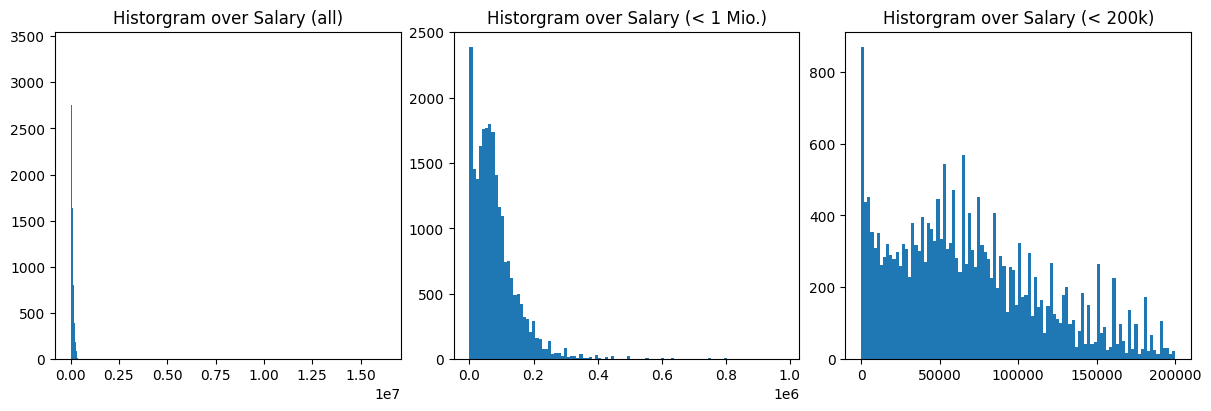

In [159]:
# Check distribution of salary

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(12, 4))
axs[0].hist(df.ConvertedCompYearly, bins = 1000) 
axs[0].set_title('Historgram over Salary (all)')
axs[1].hist(df.ConvertedCompYearly[df.ConvertedCompYearly < 1000000], bins = 100) 
axs[1].set_title('Historgram over Salary (< 1 Mio.)')
axs[2].hist(df.ConvertedCompYearly[df.ConvertedCompYearly < 200000], bins = 100) 
axs[2].set_title('Historgram over Salary (< 200k)')

plt.show()

*Issues*  to consider:
- Just a little more than 1/3 of the participants gave a salary.
- Salary extremly skewed (potentially influential outliers)
- A lot of participants gave unrealistically small salary (~ 0)


------------------------------------------------------------------------------------------------------------------------------

#### Potential features examination

To keep the model relatively simple, interpretable and usable for prediction features will only include the first two sections of the survey (1. Basic Information & 2 - Education + Work + Career.) <br>
Additionally questions `BuyNewTool`, `BuildvsBuy`, `TechEndorse` will be excluded for two main reasons:
1. No logical reason why they should influence salary
2. And more importantly, not really applicable when trying to predict an appropriate salary

`Currency` will be excluded as Salary in target is converted already and besides conversion, currency mostly represents duplicate information with country.

`LearnCodeOnline` will be excluded as it is clearly secondary information to `LearnCode`.

`TechDoc` will be excluded. This might indirectly represent a devs abilities or style of work but seems like in theory it should not *directly* influence salary.

**Exploring Features only on rows with salary!**

In [160]:
# Exploring Features only on rows with salary!
df2 = df[df.ConvertedCompYearly.notna()].copy()

# make sure to only include those that passed the check of attention in survey
# --> only those who pass can continue the survey so 100% pass in data
df2.Check.describe()



count      23435
unique         1
top       Apples
freq       23435
Name: Check, dtype: object

##### `MainBranch` & `Emplyoment`
Technically we only care about those who work as some sort of dev professionally as we want to determine what influences salary of a dev. For comparibility we stick to full time emplyoment.

In [161]:
# filter to keep only those working as some sort of dev professionally and being employed full time
df2 = df2[
    (df2['MainBranch'] == "I am a developer by profession") &
    (df2['Employment'].str.contains("Employed, full-time", na=False))
]

df2.shape

(18843, 114)

In [162]:
# preselection of features
df2 = df2[['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'PurchaseInfluence', 'Country', 'ConvertedCompYearly']]

df2.shape

(18843, 12)

In [163]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18843 entries, 72 to 41187
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  18843 non-null  object 
 1   RemoteWork           18841 non-null  object 
 2   CodingActivities     18840 non-null  object 
 3   EdLevel              18843 non-null  object 
 4   LearnCode            18815 non-null  object 
 5   YearsCode            18805 non-null  object 
 6   YearsCodePro         18789 non-null  object 
 7   DevType              18818 non-null  object 
 8   OrgSize              18825 non-null  object 
 9   PurchaseInfluence    18814 non-null  object 
 10  Country              18843 non-null  object 
 11  ConvertedCompYearly  18843 non-null  float64
dtypes: float64(1), object(11)
memory usage: 1.9+ MB


##### `YearsCode` & `YearsCodePro`

Apart from our target all columns (features) are of datatype object. <br>
`YearsCode` & `YearsCodePro` could technically be numerical. So lets check them:

In [164]:
df2.YearsCode.unique()
df2.YearsCode.value_counts()

YearsCode
10                    1692
8                     1217
15                    1081
7                     1072
6                     1041
12                     991
20                     918
5                      895
9                      850
14                     767
4                      666
11                     646
13                     594
25                     564
16                     536
18                     494
17                     430
30                     422
3                      399
22                     306
24                     304
40                     254
19                     246
23                     219
26                     210
21                     201
35                     197
2                      185
27                     173
28                     162
32                     109
34                      95
29                      92
38                      90
42                      79
33                      76
45                

In [165]:
df2.YearsCodePro.value_counts()

YearsCodePro
3                     1617
5                     1434
2                     1429
4                     1301
6                     1244
10                    1235
8                     1109
7                     1056
12                     728
1                      690
9                      658
15                     594
11                     573
13                     478
20                     472
14                     420
Less than 1 year       406
16                     372
17                     325
18                     316
25                     310
19                     210
24                     190
30                     174
23                     172
22                     169
26                     155
28                     131
21                     130
27                     118
35                      76
32                      65
29                      60
40                      53
34                      49
38                      39
33             

We can clearly see that the format of the question allowed for or explictly offered answers that cannot be converted to float or integer. <br>
These values make up only a fraction of the dataset but represent edge cases (<1 year and > 50 years). 

We have the option to exclude these values and convert the rest to integer or replace these values with an adequate integer. <br>
To ensure that the model applies to people with very little or very much coding experience as well I am going to keep the edge cases and convert them to the next integer (i.e. < 1year &rarr; 0 and >50 &rarr; 51). <br>
Furthermore I am going to treat years as continious variables.

In [166]:
# replace values

df2.replace(
    {'More than 50 years': '51', 'Less than 1 year': '0'}, inplace=True
)

# convert to int

# Convert the two columns to integers
df2['YearsCode'] = pd.to_numeric(df2['YearsCode'], errors='coerce').fillna(0).astype(int)
df2['YearsCodePro'] = pd.to_numeric(df2['YearsCodePro'], errors='coerce').fillna(0).astype(int)

# check if it worked
df2.info()

print(df2.YearsCode.value_counts())
 
print(df2.YearsCodePro.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 18843 entries, 72 to 41187
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  18843 non-null  object 
 1   RemoteWork           18841 non-null  object 
 2   CodingActivities     18840 non-null  object 
 3   EdLevel              18843 non-null  object 
 4   LearnCode            18815 non-null  object 
 5   YearsCode            18843 non-null  int64  
 6   YearsCodePro         18843 non-null  int64  
 7   DevType              18818 non-null  object 
 8   OrgSize              18825 non-null  object 
 9   PurchaseInfluence    18814 non-null  object 
 10  Country              18843 non-null  object 
 11  ConvertedCompYearly  18843 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 1.9+ MB
YearsCode
10    1692
8     1217
15    1081
7     1072
6     1041
12     991
20     918
5      895
9      850
14     767
4      666
11

array([[<Axes: xlabel='YearsCode', ylabel='YearsCode'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCode'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCode'>],
       [<Axes: xlabel='YearsCode', ylabel='YearsCodePro'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCodePro'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCodePro'>],
       [<Axes: xlabel='YearsCode', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='YearsCodePro', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='ConvertedCompYearly'>]],
      dtype=object)

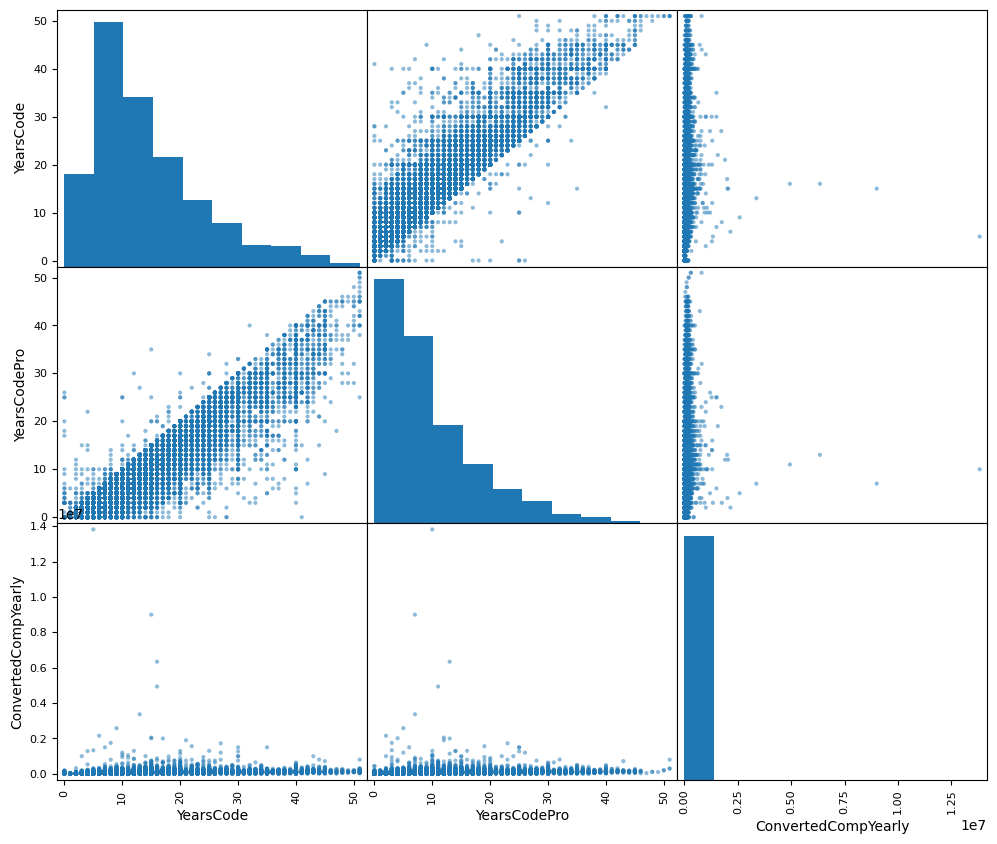

In [167]:
scatter_matrix(df2[['YearsCode', 'YearsCodePro', 'ConvertedCompYearly']], figsize=(12, 10))

We can see that both `YearsCode` and `YearsCodePro`have a right skewed distribution. <br>

These two variables are clearly correlated &rarr; potentially colinearity <br>

No clear relationship visible between `YearsCode` and `YearsCodePro` and our target. But might at least partially be obscured by the outliers. <br>

In [168]:
# check categorical features for imbalance
cat_features = ['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly']

for f in cat_features:
    print(f'{f}:')
    
    print(df2[f].value_counts())

Age:
Age
25-34 years old       8860
35-44 years old       5019
18-24 years old       2568
45-54 years old       1692
55-64 years old        606
65 years or older       72
Under 18 years old      18
Prefer not to say        8
Name: count, dtype: int64
RemoteWork:
RemoteWork
Hybrid (some remote, some in-person)    8071
Remote                                  7572
In-person                               3198
Name: count, dtype: int64
CodingActivities:
CodingActivities
Hobby                                                                                                                                                                                                      3723
Hobby;Professional development or self-paced learning from online courses                                                                                                                                  2507
I don’t code outside of work                                                                                      

##### `CodingActivities`

In [169]:
# For simplicity and essentially interpretability of the model we will only distinguish between those that code outside of work and those who don't
# The number pf possible combination of coding activities outside of work would make the model very hard to interpret
# print(df2['CodingActivities'].unique())

# 0 = dont code outside of work
df2['CodingOutsideOfWork'] = 1
df2.loc[df2['CodingActivities'].str.contains("I don’t code outside of work", na=False), 'CodingOutsideOfWork'] = 0
df2.drop(['CodingActivities'], axis=1, inplace=True)
df2.CodingOutsideOfWork.value_counts()

CodingOutsideOfWork
1    16546
0     2297
Name: count, dtype: int64

In [170]:
# For the same reason (interpretability) we will only include one dummy / boolean for each learning type instead of including each possible combination of learning experiences as dummies

df2['PhysicalMedia'] = 0
df2.loc[df2['LearnCode'].str.contains('Books / Physical media', na=False), 'PhysicalMedia'] = 1
print(df2.PhysicalMedia.value_counts())

df2['Bootcamp'] = 0
df2.loc[df2['LearnCode'].str.contains('Coding Bootcamp', na=False), 'Bootcamp'] = 1
print(df2.Bootcamp.value_counts())


df2['Colleague'] = 0
df2.loc[df2['LearnCode'].str.contains('Colleague', na=False), 'Colleague'] = 1
print(df2.Colleague.value_counts())


df2['FriendFamily'] = 0
df2.loc[df2['LearnCode'].str.contains('Friend or family member', na=False), 'FriendFamily'] = 1
print(df2.FriendFamily.value_counts())


df2['Online'] = 0
df2.loc[df2['LearnCode'].str.contains('Online Courses or Certification', na=False), 'Online'] = 1
print(df2.Online.value_counts())


df2['Job'] = 0
df2.loc[df2['LearnCode'].str.contains('On the job training', na=False), 'Job'] = 1
print(df2.Job.value_counts())


df2['OnlineOther'] = 0
df2.loc[df2['LearnCode'].str.contains('Other online resources', na=False), 'OnlineOther'] = 1
print(df2.OnlineOther.value_counts())


df2['School'] = 0
df2.loc[df2['LearnCode'].str.contains('School', na=False), 'School'] = 1
print(df2.School.value_counts())

df2.drop(['LearnCode'], axis=1, inplace=True)



PhysicalMedia
1    9766
0    9077
Name: count, dtype: int64
Bootcamp
0    16919
1     1924
Name: count, dtype: int64
Colleague
0    13635
1     5208
Name: count, dtype: int64
FriendFamily
0    17014
1     1829
Name: count, dtype: int64
Online
1    9642
0    9201
Name: count, dtype: int64
Job
1    9971
0    8872
Name: count, dtype: int64
OnlineOther
1    15521
0     3322
Name: count, dtype: int64
School
1    9551
0    9292
Name: count, dtype: int64


##### `Age`

*Unfortunately* age is available only in categories. This leaves us with the decision to either treat it as ordinal data and dummy encode each range which would ignore the innate order. <br>
Alternatively we can treat it as ordinal and encode with `OrdinalEncoder`, which is what we are going to do to keep the most information. <br>

*'I prefer no to say'* will be treated as missing value.

In [171]:
df2.replace(
    {'Prefer not to say': np.nan}, inplace=True
)
df2.Age.unique()

array(['18-24 years old', '35-44 years old', '25-34 years old',
       '45-54 years old', '55-64 years old', '65 years or older',
       'Under 18 years old', nan], dtype=object)

In [172]:
encoder = OrdinalEncoder(categories=[['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old', '45-54 years old', '55-64 years old', '65 years or older', np.nan]],
                        dtype=float, encoded_missing_value=np.nan)
df2['age_encoded'] = encoder.fit_transform(df2[['Age']])

df2.drop(['Age'], axis=1, inplace=True)


df2.age_encoded.unique()

array([ 1.,  3.,  2.,  4.,  5.,  6.,  0., nan])

##### `Countries`

We are going to handle all countries that occur less than 50 times as other. 50 is somewhat arbitrary, but there are just to many countries. In the end the pruning of the tree / limitations in depth will limit the included countries anyway to avoid overly complex models.

In [173]:
counts = df['Country'].value_counts()

df2['Country_grouped'] = df2['Country'].apply(lambda x: x if counts[x] >= 50 else 'Other').replace(regex=' ', value='_')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df2[['Country_grouped']])


encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(['Country_grouped']),
    index=df2.index
)

df2 = pd.concat([df2.drop(columns=['Country', 'Country_grouped']), encoded_df], axis=1)
df2.head()

,RemoteWork,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,ConvertedCompYearly,CodingOutsideOfWork,PhysicalMedia,...,Country_grouped_Tunisia,Country_grouped_Turkey,Country_grouped_Ukraine,Country_grouped_United_Arab_Emirates,Country_grouped_United_Kingdom_of_Great_Britain_and_Northern_Ireland,Country_grouped_United_States_of_America,Country_grouped_Uruguay,Country_grouped_Uzbekistan,"Country_grouped_Venezuela,_Bolivarian_Republic_of...",Country_grouped_Viet_Nam
72,"Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",3,1,Data scientist or machine learning specialist,100 to 499 employees,I have some influence,7322.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,91295.0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,Remote,Some college/university study without earning ...,7,7,Student,10 to 19 employees,I have some influence,110000.0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
392,"Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",32,18,Engineering manager,"1,000 to 4,999 employees",I have little or no influence,161044.0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
395,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",32,25,Other (please specify):,20 to 99 employees,I have a great deal of influence,121018.0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### `RemoteWork`

In [174]:
df2 = pd.get_dummies(df2, columns=['RemoteWork'], dtype=float)
df2.head()

,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,ConvertedCompYearly,CodingOutsideOfWork,PhysicalMedia,Bootcamp,...,Country_grouped_United_Arab_Emirates,Country_grouped_United_Kingdom_of_Great_Britain_and_Northern_Ireland,Country_grouped_United_States_of_America,Country_grouped_Uruguay,Country_grouped_Uzbekistan,"Country_grouped_Venezuela,_Bolivarian_Republic_of...",Country_grouped_Viet_Nam,"RemoteWork_Hybrid (some remote, some in-person)",RemoteWork_In-person,RemoteWork_Remote
72,"Secondary school (e.g. American high school, G...",3,1,Data scientist or machine learning specialist,100 to 499 employees,I have some influence,7322.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
379,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,91295.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
389,Some college/university study without earning ...,7,7,Student,10 to 19 employees,I have some influence,110000.0,1,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
392,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",32,18,Engineering manager,"1,000 to 4,999 employees",I have little or no influence,161044.0,1,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
395,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",32,25,Other (please specify):,20 to 99 employees,I have a great deal of influence,121018.0,1,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##### `EdLevel`

While there is some order of education level this does not hold true for all categories (different types rather than different level), therefore we stick to dummy encoding.


In [175]:
df2 = pd.get_dummies(df2, columns=['EdLevel'], dtype=float)
df2.head()

,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,ConvertedCompYearly,CodingOutsideOfWork,PhysicalMedia,Bootcamp,Colleague,...,RemoteWork_In-person,RemoteWork_Remote,"EdLevel_Associate degree (A.A., A.S., etc.)","EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)","EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",EdLevel_Primary/elementary school,"EdLevel_Professional degree (JD, MD, Ph.D, Ed.D, etc.)","EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",EdLevel_Some college/university study without earning a degree,EdLevel_Something else
72,3,1,Data scientist or machine learning specialist,100 to 499 employees,I have some influence,7322.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
379,15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,91295.0,1,1,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
389,7,7,Student,10 to 19 employees,I have some influence,110000.0,1,1,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
392,32,18,Engineering manager,"1,000 to 4,999 employees",I have little or no influence,161044.0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
395,32,25,Other (please specify):,20 to 99 employees,I have a great deal of influence,121018.0,1,1,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### `DevType`

'Other' will be treated as as other together with those jobs with less than 30 occurences. Again 30 is somewhat arbitrary. A smaller value was chosen since less categories exist than with country.

In [176]:
counts = df['DevType'].value_counts()

df2['DevType_grouped'] = df2['DevType'].apply(
    lambda x: x if counts.get(x, 0) >= 30 and 'Other (please specify):' not in x else 'Other'
).str.replace(' ', '_', regex=False)

df2 = pd.get_dummies(df2, columns=['DevType_grouped'], dtype=float).drop(columns=['DevType'])
df2.head()

,YearsCode,YearsCodePro,OrgSize,PurchaseInfluence,ConvertedCompYearly,CodingOutsideOfWork,PhysicalMedia,Bootcamp,Colleague,FriendFamily,...,DevType_grouped_Marketing_or_sales_professional,DevType_grouped_Other,DevType_grouped_Product_manager,DevType_grouped_Project_manager,DevType_grouped_Research_&_Development_role,DevType_grouped_Scientist,DevType_grouped_Security_professional,"DevType_grouped_Senior_Executive_(C-Suite,_VP,_etc.)",DevType_grouped_Student,DevType_grouped_System_administrator
72,3,1,100 to 499 employees,I have some influence,7322.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,15,6,20 to 99 employees,I have a great deal of influence,91295.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,7,7,10 to 19 employees,I have some influence,110000.0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
392,32,18,"1,000 to 4,999 employees",I have little or no influence,161044.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,32,25,20 to 99 employees,I have a great deal of influence,121018.0,1,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### `OrgSize`

OrgSize can be considered ordinal, so we'll use OrdinalEncoder. <br>
*'I don't know'* will be treated as missing values. <br>
*'Just me - I am a freelancer, sole proprietor, etc.'* will be excluded. While one could argue that it is the smallest OrgSize, it is also indicative of a potentially very different type of organization. Also freelancing and self-employment does not fit into the theme of traditional salary decisions and negotiation. <br>

In [177]:
# remove freelancing and self-employment
df2 = df2[
    df2['OrgSize'] != "Just me - I am a freelancer, sole proprietor, etc."
]

df2.shape


(18735, 144)

In [178]:
df2.replace(
    {'I don’t know': np.nan}, inplace=True
)

# encode 'OrgSize'
encoder = OrdinalEncoder(categories=[['2 to 9 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', '500 to 999 employees',
                                      '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees', np.nan]],
                        dtype=float, encoded_missing_value=np.nan)
df2['OrgSize_encoded'] = encoder.fit_transform(df2[['OrgSize']])

df2.drop(['OrgSize'], axis=1, inplace=True)


df2.OrgSize_encoded.unique()

array([ 3.,  2.,  1.,  5.,  7.,  0., nan,  4.,  6.])

In [179]:
df2.head()

,YearsCode,YearsCodePro,PurchaseInfluence,ConvertedCompYearly,CodingOutsideOfWork,PhysicalMedia,Bootcamp,Colleague,FriendFamily,Online,...,DevType_grouped_Other,DevType_grouped_Product_manager,DevType_grouped_Project_manager,DevType_grouped_Research_&_Development_role,DevType_grouped_Scientist,DevType_grouped_Security_professional,"DevType_grouped_Senior_Executive_(C-Suite,_VP,_etc.)",DevType_grouped_Student,DevType_grouped_System_administrator,OrgSize_encoded
72,3,1,I have some influence,7322.0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
379,15,6,I have a great deal of influence,91295.0,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
389,7,7,I have some influence,110000.0,1,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
392,32,18,I have little or no influence,161044.0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
395,32,25,I have a great deal of influence,121018.0,1,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


##### `PurchaseInfluence`

`PurchaseInfluence` can be considered ordinal as well, so well use ordinal encoder once again.

In [180]:
df2.PurchaseInfluence.unique()

# encode 'OrgSize'
encoder = OrdinalEncoder(categories=[['I have little or no influence', 'I have some influence', 'I have a great deal of influence',  np.nan]],
                        dtype=float, encoded_missing_value=np.nan)
df2['PurchaseInfluence_encoded'] = encoder.fit_transform(df2[['PurchaseInfluence']])

df2.drop(['PurchaseInfluence'], axis=1, inplace=True)


df2.PurchaseInfluence_encoded.unique()

array([ 1.,  2.,  0., nan])

In [181]:
df2.head()

,YearsCode,YearsCodePro,ConvertedCompYearly,CodingOutsideOfWork,PhysicalMedia,Bootcamp,Colleague,FriendFamily,Online,Job,...,DevType_grouped_Product_manager,DevType_grouped_Project_manager,DevType_grouped_Research_&_Development_role,DevType_grouped_Scientist,DevType_grouped_Security_professional,"DevType_grouped_Senior_Executive_(C-Suite,_VP,_etc.)",DevType_grouped_Student,DevType_grouped_System_administrator,OrgSize_encoded,PurchaseInfluence_encoded
72,3,1,7322.0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
379,15,6,91295.0,1,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
389,7,7,110000.0,1,1,0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
392,32,18,161044.0,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
395,32,25,121018.0,1,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


Now everything is encoded and numerical! 


Attention to imbalances:
- age (young and old underepresented)
- education (very high and low level of education underrepresented)
- large minority codes outside of work
- imbalances in learning resources
- imbalance in jobs

**For now i am going to keep these imbalances in mind but won't try to rectify them. Most of these 'imbalances' are akin to the usual normal distribution in a large sample (e.g.) age and higher accuracy within these ranges with higher density is not necessarily bad if the (target) population shows similar distribution tendencies.**

In [192]:
df2.isna().sum()

YearsCode                                                 0
YearsCodePro                                              0
ConvertedCompYearly                                       0
CodingOutsideOfWork                                       0
PhysicalMedia                                             0
                                                       ... 
DevType_grouped_Senior_Executive_(C-Suite,_VP,_etc.)      0
DevType_grouped_Student                                   0
DevType_grouped_System_administrator                      0
OrgSize_encoded                                         263
PurchaseInfluence_encoded                                28
Length: 144, dtype: int64

#### Missing values

With the small number of missing values (relative to sample size) i could remove rows with missing values or impute. Both should have little influence. <br>
I decided for a simple imputation. 

## Model development

I decided to go with a **Decision Tree** for regression of the salary. <br>
This is because most selected features are unlikely (or guarenteed not to have) to have a linear relationship with the target. Decision trees tend to work well with non linear relationships. <br>

Furthermore, I am looking for a model that allows for clear interpretation of the factors influencing the expected salary. <br>
Again Decision Trees are a good choice in that regard (if the number of branches is kept relatively small). 

Handle high outliers by leaf median for prediction.

0 exclued

## Prediction Scenario